# Introduction to Machine Learning Methodology

## How do I choose the best approach?

There's two ways of varying the approach to modelling,

* choose a different algorithm
* change the input to the same algorithm
    * not the data, but
    * **the hyper-parameters**
    
They amount to the same thing: any variation in approach *produces a distinct model*.

In [5]:
import seaborn as sns
tips = sns.load_dataset('tips')

In [22]:
X = tips[['total_bill', 'size']]
y = tips['tip']

In [3]:
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.neighbors import KNeighborsRegressor

In ML we typically brute-force our way to "good solution", ie., we try a lot of different approaches,

In [11]:
approaches = [
    LinearRegression(),
    Lasso(),
    KNeighborsRegressor(1),
    KNeighborsRegressor(3),
    KNeighborsRegressor(7),
    KNeighborsRegressor(21),
    KNeighborsRegressor(41),
]

With each we will `.fit()` and then `.score()` (ie., compute the total loss), 

In [23]:
scores = []

# REPEAT .fit, .score FOR EVERY a IN approaches
for a in approaches:
    # fit
    a.fit(X, y)
    
    # sklearn chooses a default error formula
    # eg., mse for many approaches
    score = a.score(X, y)
    
    # remeber the scores and approaches
    scores.append( (score, a) )

In [24]:
max(scores)

(0.9896142080482307, KNeighborsRegressor(n_neighbors=1))

## Is this brute-force approach correct?

What are we really interested in?

We want our model to generalise. We do not care how well `.predict` performs on the data it has already seen. (We already know the answers...).

We really want to know how well it will perform in the future. We can't sample from the future. We can however *hide* data, and see how well it performs on that...

In [20]:
from sklearn.model_selection import train_test_split

In [41]:
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2) # 80/20 split

In [42]:
len(Xtr), len(ytr)

(195, 195)

In [43]:
len(Xte), len(yte)

(49, 49)

In [44]:
scores_val = []

# REPEAT .fit, .score FOR EVERY a IN approaches
for a in approaches:
    # fit
    a.fit(Xtr, ytr)
    
    # sklearn chooses a default error formula
    # eg., mse for many approaches
    score = a.score(Xte, yte)
    
    # remeber the scores and approaches
    scores_val.append( (score, a) )

In [45]:
scores_val

[(0.5577043209190853, LinearRegression()),
 (0.5242374096442314, Lasso()),
 (0.029998947549712107, KNeighborsRegressor(n_neighbors=1)),
 (0.5231710060195016, KNeighborsRegressor(n_neighbors=3)),
 (0.515269663025825, KNeighborsRegressor(n_neighbors=7)),
 (0.4880547006625572, KNeighborsRegressor(n_neighbors=21)),
 (0.45476621653817006, KNeighborsRegressor(n_neighbors=41))]

Using this approach we find the *exact opposite* of what the naive approach recommended,

In [47]:
max(scores) # knn, k=1 *best model*  where fit(data) same as score(data)

(0.9896142080482307, KNeighborsRegressor(n_neighbors=1))

In [48]:
min(scores_val) # knn=1 is the *worse* where fit(training_set) different from score(validation_set) 

(0.029998947549712107, KNeighborsRegressor(n_neighbors=1))

In [49]:
max(scores_val)

(0.5577043209190853, LinearRegression())

#### Aside: does train-test-split ensure traning/test have the same distribution?

It will randomise the columns before splitting, so train ~= test,

In [52]:
tips['day']

0       Sun
1       Sun
2       Sun
3       Sun
4       Sun
       ... 
239     Sat
240     Sat
241     Sat
242     Sat
243    Thur
Name: day, Length: 244, dtype: category
Categories (4, object): [Thur, Fri, Sat, Sun]

.... We should statistically test the two datasets,

In [54]:
Xtr.mean(), Xtr.std()

(total_bill    19.734000
 size           2.533333
 dtype: float64,
 total_bill    8.990449
 size          0.915315
 dtype: float64)

In [55]:
Xte.mean(), Xtr.std()

(total_bill    19.992653
 size           2.714286
 dtype: float64,
 total_bill    8.990449
 size          0.915315
 dtype: float64)

## What is a general methodology for Machine Learning?

* obtain data + EDA
    * `load_dataset`
* prep data + EDA
    * `dropna`
* choose features and target + EDA
    * `X = ...`
    * `y = ...`
* split train/test
    * test will provide evaluation
* select the best model
    * cross validate with training data
    * repeat 80/20 split many times *per algorithm*
        * so that it sees all points in test/train phases
* evaluate the best model
    * on the test data
* deploy 
    * report, software, ...

    

In [62]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

In [74]:
# 1. obtain

titanic = sns.load_dataset('titanic')

# 2. prepare

cleaned = titanic.drop(columns=['deck']).dropna()

# 3. choose X,y

X = cleaned[['age', 'fare', 'pclass']]
y = cleaned['survived']

# 4. split

Xtr, Xte, ytr, yte = train_test_split(X, y)


# 4. choose best model

scores = []

scores.append( (cross_val_score(KNeighborsClassifier(3), Xtr, ytr).mean(), 3) )
scores.append( (cross_val_score(KNeighborsClassifier(5), Xtr, ytr).mean(), 5) )
scores.append( (cross_val_score(KNeighborsClassifier(7), Xtr, ytr).mean(), 7) )
scores.append( (cross_val_score(KNeighborsClassifier(21), Xtr, ytr).mean(), 21) )
scores.append( (cross_val_score(KNeighborsClassifier(41), Xtr, ytr).mean(), 41) )

best = max(scores)

# evaluate the best model

best_score = KNeighborsClassifier(best[1]).fit(Xtr, ytr).score(Xte, yte)

In [75]:
best_score

0.7134831460674157

```

                 X, y 
                 
                   |-> split ->  TEST, TRAIN, 
                                   |     |
                                   |     |-> A1.fit(80% TRAIN).score(20% TRAIN) for 5 splits
                                   |     |-> A2.fit(80% TRAIN).score(20% TRAIN) for 5 splits
                                   |     |-> A3.fit(80% TRAIN).score(20% TRAIN) for 5 splits
                                   |     |-> choose best, eg., A3
                                   |
                                   |-> A3(TRAIN).score(TEST) score on unseen data
                                   
               |-> REPORT: BEST MODEL, SCORE OF BEST MODEL
```



NB. `cross_val_score` just means `.fit(80% TRAIN).score(20% TRAIN) for 5 splits`

## Exercise

* Perform a `kNN` fitting for a prediction problem
    * eg., predict survivial on titanic (classification)
    * eg., predict tip on tips (regression)

* Use `cross_val_score` to record a history of `k` vs `mean score`

* Plot this using `sns.lineplot`
    * and therefore show, visually, the best `k`

In [76]:
scores

[(0.6478398871451242, 3),
 (0.6515429377534826, 5),
 (0.6590195732675014, 7),
 (0.6946570269793686, 21),
 (0.660994533591959, 41)]

In [78]:

scores_1to41 = []

for k in range(1, 41):
    scores_1to41.append(cross_val_score(KNeighborsClassifier(k), Xtr, ytr).mean())


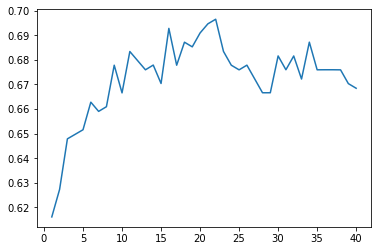

In [79]:
sns.lineplot(x=range(1, 41), y=scores_1to41)

In [82]:
import numpy as np

Aside, there is a useful function in `numpy` which provides the index of the maximum entry,

In [84]:
np.argmax(scores_1to41)

21

## Review

Graphs of the type, ie., where the validation score is on the vertical and a hyperparameter is on the horizontal, are very important in ML.


They show the *performance* of our various approaches and thereby allows to choose the best at-a-glance.

Aside, why not always just use `max`, etc. -- visually you may see the score being "flat" for a lot of approaches, and here the advice is then to choose the simplest. 